In [167]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [168]:
df = pd.read_csv("Aluminium 25 years Quarterly.csv")

In [169]:
df.head(5)

,DATE,PALUMUSDQ
0,1999-04-01,1305.501435
1,1999-07-01,1439.040765
2,1999-10-01,1500.166815
3,2000-01-01,1646.305000
4,2000-04-01,1478.727648


In [170]:
df.tail()

,DATE,PALUMUSDQ
96,2023-04-01,2265.632415
97,2023-07-01,2159.995977
98,2023-10-01,2196.217201
99,2024-01-01,2203.488523
100,2024-04-01,2521.050792


In [171]:
# Renaming columns
df = df.rename(columns = {'DATE': 'YEAR', 'PALUMUSDQ': 'PRICE IN DOLLARS PER METRIC TONS'})

In [172]:
df.head()

,YEAR,PRICE IN DOLLARS PER METRIC TONS
0,1999-04-01,1305.501435
1,1999-07-01,1439.040765
2,1999-10-01,1500.166815
3,2000-01-01,1646.305000
4,2000-04-01,1478.727648


In [173]:
# # Convert 'Year' to datetime and set it as the index
# df['YEAR'] = pd.to_datetime(df['YEAR'])
# df.set_index('YEAR', inplace=True)

# Convert 'YEAR' column to datetime
df['YEAR'] = pd.to_datetime(df['YEAR'], errors='coerce')

# Extract the year as a numeric feature
df['YEAR_NUM'] = df['YEAR'].dt.year


In [174]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Reshape the column to 2D and apply scaling
df['PRICE IN DOLLARS PER METRIC TONS'] = scaler.fit_transform(df['PRICE IN DOLLARS PER METRIC TONS'].values.reshape(-1, 1))

# Use ravel() to flatten the scaled data back to 1D
df['PRICE IN DOLLARS PER METRIC TONS'] = df['PRICE IN DOLLARS PER METRIC TONS'].values.ravel()

# Now the 'PRICE IN DOLLARS' column is scaled
print(df.head())

        YEAR  PRICE IN DOLLARS PER METRIC TONS  YEAR_NUM
0 1999-04-01                         -1.494359      1999
1 1999-07-01                         -1.193158      1999
2 1999-10-01                         -1.055287      1999
3 2000-01-01                         -0.725670      2000
4 2000-04-01                         -1.103644      2000


In [175]:
# Checking for outliers

def detect_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detecting outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Example usage
outliers, lower_bound, upper_bound = detect_outliers_iqr(df, 'PRICE IN DOLLARS PER METRIC TONS')
print("Detected outliers:\n", outliers)

Detected outliers:
          YEAR  PRICE IN DOLLARS PER METRIC TONS  YEAR_NUM
91 2022-01-01                          2.891601      2022


In [176]:
# Removing outliers
df = df[~df['PRICE IN DOLLARS PER METRIC TONS'].isin(outliers['PRICE IN DOLLARS PER METRIC TONS'])]
print(f"DataFrame size after removing outliers: {df.shape}")

DataFrame size after removing outliers: (100, 3)


In [177]:
df.head()

,YEAR,PRICE IN DOLLARS PER METRIC TONS,YEAR_NUM
0,1999-04-01,-1.494359,1999
1,1999-07-01,-1.193158,1999
2,1999-10-01,-1.055287,1999
3,2000-01-01,-0.725670,2000
4,2000-04-01,-1.103644,2000


In [178]:
print(df.columns)

Index(['YEAR', 'PRICE IN DOLLARS PER METRIC TONS', 'YEAR_NUM'], dtype='object')


In [179]:
# Split the data into features (X) and target (y)
X = df[['YEAR_NUM']]  # Use the numeric year column
y = df['PRICE IN DOLLARS PER METRIC TONS']  # Target variable

In [180]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [182]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

In [183]:
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [184]:
# Fit the grid search model
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [185]:
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best model: {best_model}")

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best model: RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)


In [186]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [187]:
# Predict on the training data to get training scores
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Display the training scores
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")

Training R² Score: 0.8486
Training MAE: 0.2613
Training MSE: 0.1312


In [188]:
# Predict on the test data to get testing scores
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Display the testing scores

print(f"Testing R² Score: {test_r2:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R² Score: 0.8398
Testing MAE: 0.3433
Testing MSE: 0.1856


In [189]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [191]:
# Print the evaluation results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.3433020933221048
Mean Squared Error (MSE): 0.18564542003985576
Root Mean Squared Error (RMSE): 0.43086589565647426
R-squared (R²): 0.839791550729393


In [192]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [193]:
# Predict on the training data
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Display the training and testing scores
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")

Training R² Score: 0.1388
Training MAE: 0.6729
Training MSE: 0.7461


In [194]:
# Predict on the test data
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Testing R² Score: {test_r2:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R² Score: 0.1444
Testing MAE: 0.8056
Testing MSE: 0.9915


In [195]:
y_pred

array([-0.53562611,  0.23686421, -0.85499901,  0.61359521,  0.61359521,
       -0.28028224, -0.67178332, -0.34484843, -1.07335201, -1.04296747,
       -1.31353236,  1.23765192,  0.00499087,  1.42651355,  0.93208517,
       -0.95736177,  0.06260388,  0.06260388, -1.34061949,  1.42651355])

In [196]:
X_test

,YEAR_NUM
83,2020
53,2012
70,2016
45,2010
44,2010
39,2009
22,2004
80,2019
10,2001
0,1999


In [197]:
y_test

83   -0.625553
53   -0.090528
70   -0.581436
45    0.275642
44    0.288925
39   -1.359030
22   -0.303367
80   -0.392062
10   -1.456613
0    -1.494359
18   -1.020637
30    1.713330
73    0.094249
33    1.309366
90    1.776050
4    -1.103644
76    0.667534
77    0.192551
12   -1.377642
31    1.872895
Name: PRICE IN DOLLARS PER METRIC TONS, dtype: float64

In [198]:
y_pred

array([-0.53562611,  0.23686421, -0.85499901,  0.61359521,  0.61359521,
       -0.28028224, -0.67178332, -0.34484843, -1.07335201, -1.04296747,
       -1.31353236,  1.23765192,  0.00499087,  1.42651355,  0.93208517,
       -0.95736177,  0.06260388,  0.06260388, -1.34061949,  1.42651355])

In [199]:
# Create a DataFrame for easier plotting
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})



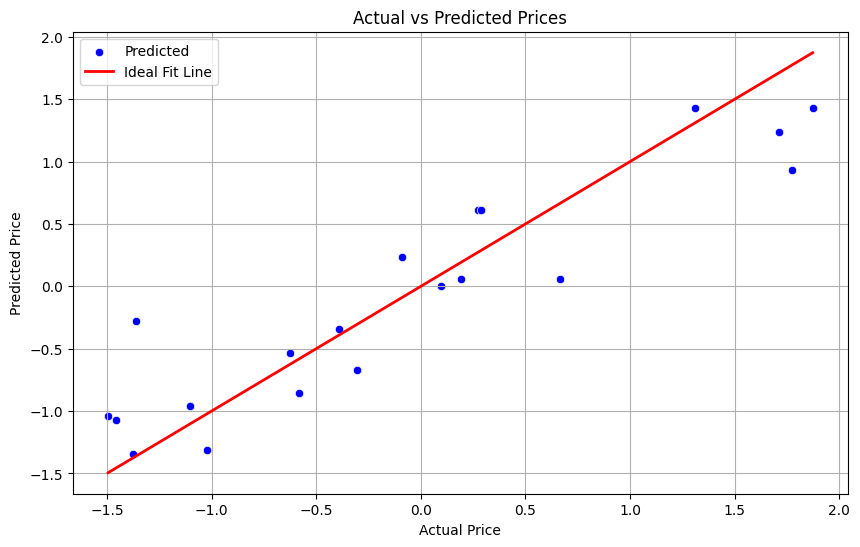

In [200]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit Line')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

In [201]:
X_test['YEAR_NUM'] = pd.to_numeric(X_test['YEAR_NUM'], errors='coerce')

In [202]:
# Create a DataFrame for plotting with 'YEAR_NUM'
results_df = pd.DataFrame({
    'Year': X_test['YEAR_NUM'],  # Make sure 'YEAR_NUM' is converted correctly
    'Actual': y_test,
    'Predicted': y_pred
})

In [203]:
# Sort the dataframe by 'Year' to ensure the plot is in chronological order
results_df = results_df.sort_values(by='Year')

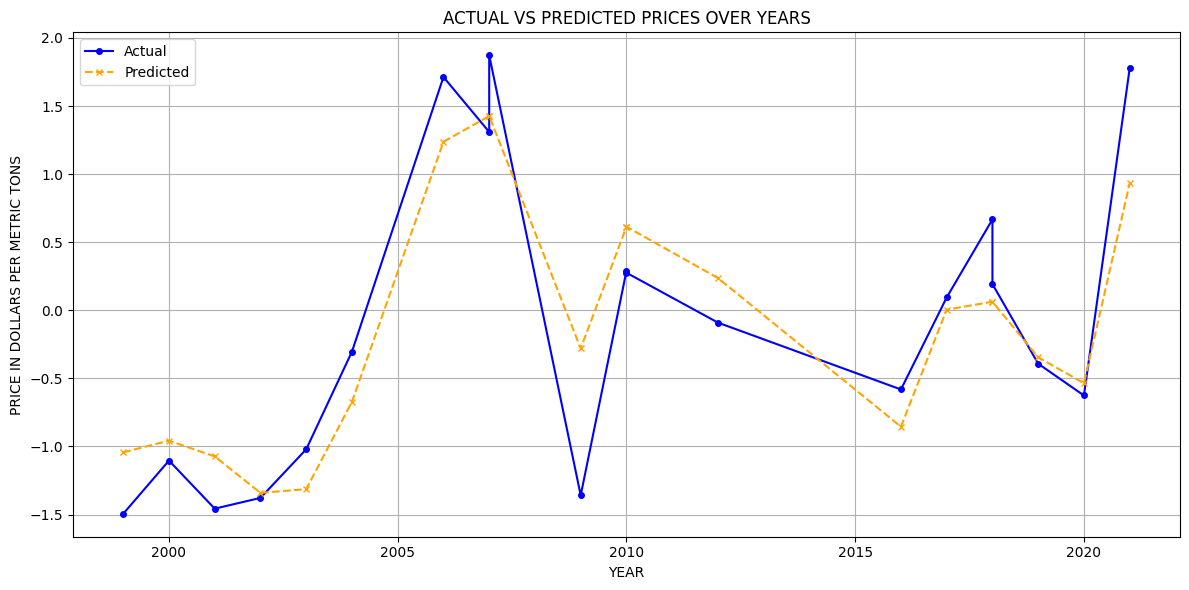

In [204]:
# Plotting the actual vs predicted values with 'Year' as the x-axis
plt.figure(figsize=(12, 6))
plt.plot(results_df['Year'], results_df['Actual'], label='Actual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(results_df['Year'], results_df['Predicted'], label='Predicted', color='orange', marker='x', linestyle='--', markersize=4)

# Add labels, title, and legend
plt.xlabel('YEAR')
plt.ylabel('PRICE IN DOLLARS PER METRIC TONS')
plt.title('ACTUAL VS PREDICTED PRICES OVER YEARS')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Correlation Matrix

In [205]:
# Plotting correlation matrix

# Create a DataFrame with actual and predicted values
correlation_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [206]:
# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

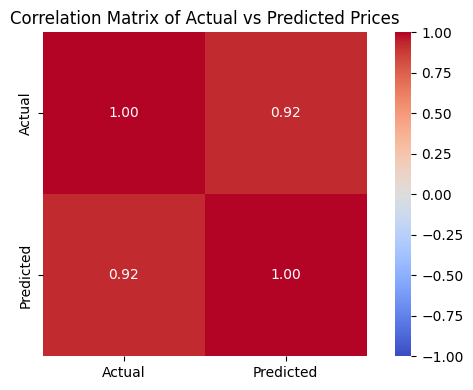

In [207]:
# Plot the correlation matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt='.2f')

# Add title
plt.title('Correlation Matrix of Actual vs Predicted Prices')

# Show the plot
plt.tight_layout()
plt.show()

In [166]:
# Train the model on the training data
model.fit(X_train, y_train)



# Predict on the test data to check test accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display the accuracies
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

1/1 [==============================] - 0s 226ms/step


ValueError: continuous is not supported

# Applying neural networks to improve the performance of model

In [208]:
# Scaling the features to normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [209]:
# Define the neural network model
model = Sequential()

In [210]:
# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer with 32 neurons and ReLU activation
model.add(Dense(16, activation='relu'))

# Third hidden layer with 16 neurons and ReLU activation
model.add(Dense(8, activation='relu'))

# Output layer with a single neuron (since it's a regression task)
model.add(Dense(1, activation='linear'))


In [211]:
# Compile the model with Adam optimizer and MSE loss function
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [212]:
# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=30, batch_size=8, verbose=1)

Epoch 1/30
10/10 [==============================] - 1s 15ms/step - loss: 0.9001 - mean_absolute_error: 0.7873 - val_loss: 1.1106 - val_mean_absolute_error: 0.8740
Epoch 2/30
10/10 [==============================] - 0s 4ms/step - loss: 0.8099 - mean_absolute_error: 0.7395 - val_loss: 1.0590 - val_mean_absolute_error: 0.8436
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 0.7746 - mean_absolute_error: 0.7136 - val_loss: 1.0202 - val_mean_absolute_error: 0.8149
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.7547 - mean_absolute_error: 0.6898 - val_loss: 0.9967 - val_mean_absolute_error: 0.8007
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7391 - mean_absolute_error: 0.6753 - val_loss: 0.9788 - val_mean_absolute_error: 0.7836
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7236 - mean_absolute_error: 0.6588 - val_loss: 0.9683 - val_mean_absolute_error: 0.7762
Epoch 7/30
10/10 [=========

In [213]:
# Evaluate the model and make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

1/1 [==============================] - 0s 20ms/step


In [214]:
# Calculate performance metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Print the performance metrics
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")

Training R² Score: 0.4873
Training MAE: 0.5225
Training MSE: 0.4442


In [215]:
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)


print(f"Testing R² Score: {test_r2:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R² Score: 0.4042
Testing MAE: 0.6294
Testing MSE: 0.6904


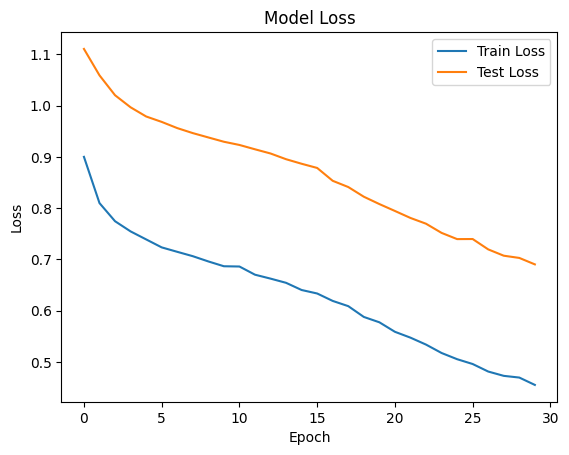

In [216]:
# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [217]:
# Input layer and first hidden layer with 32 neurons and ReLU activation, add dropout
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Drop 30% of the neurons during training

# Second hidden layer with 16 neurons and ReLU activation, add dropout
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Third hidden layer with 8 neurons and ReLU activation, add dropout
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))

In [218]:
# Output layer with a single neuron for regression
model.add(Dense(1, activation='linear'))

In [219]:
# Compile the model with Adam optimizer and Mean Squared Error (MSE) loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [220]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [238]:
# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test), 
                    epochs=60, 
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[early_stopping])

Epoch 1/60
3/3 [==============================] - 0s 33ms/step - loss: 0.5841 - mean_absolute_error: 0.5999 - val_loss: 0.7317 - val_mean_absolute_error: 0.6537
Epoch 2/60
3/3 [==============================] - 0s 16ms/step - loss: 0.6013 - mean_absolute_error: 0.5990 - val_loss: 0.7318 - val_mean_absolute_error: 0.6539
Epoch 3/60
3/3 [==============================] - 0s 16ms/step - loss: 0.5891 - mean_absolute_error: 0.6106 - val_loss: 0.7321 - val_mean_absolute_error: 0.6539
Epoch 4/60
3/3 [==============================] - 0s 16ms/step - loss: 0.5848 - mean_absolute_error: 0.6060 - val_loss: 0.7324 - val_mean_absolute_error: 0.6541
Epoch 5/60
3/3 [==============================] - 0s 10ms/step - loss: 0.5510 - mean_absolute_error: 0.5806 - val_loss: 0.7322 - val_mean_absolute_error: 0.6540
Epoch 6/60
3/3 [==============================] - 0s 17ms/step - loss: 0.5649 - mean_absolute_error: 0.5890 - val_loss: 0.7319 - val_mean_absolute_error: 0.6540
Epoch 7/60
3/3 [==================

In [234]:
# Evaluate the model and make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

1/1 [==============================] - 0s 18ms/step


In [235]:
# Calculate performance metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Print the performance metrics
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")


Training R² Score: 0.3884
Training MAE: 0.5502
Training MSE: 0.5299


In [236]:
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Testing R² Score: {test_r2:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Testing R² Score: 0.3655
Testing MAE: 0.6541
Testing MSE: 0.7353


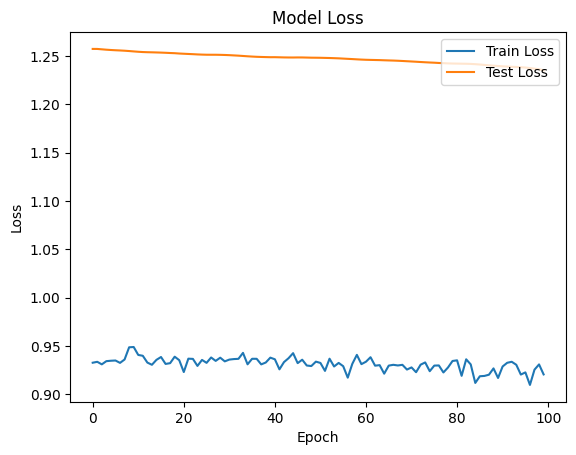

In [165]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()